# Introduccion

Buscamos predecir la tasa de cancelación de los clientes de una empresa de telecomunicaciones llamada Interconnect para anticiparse a posibles bajas. 
Con esta información; la empresa podrá ofrecer promociones y planes personalizados a los usuarios que muestren señales de querer cancelar sus servicios. 
Para ello, se han recopilado datos personales y de suscripción de los clientes, lo que permitirá el análisis para desarrollar modelos predictivos que optimicen las estrategias de retención."

El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

# Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

# Importamos librerias y Cargamos datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

In [2]:
# Leer cada archivo CSV en un DataFrame
df_1 = pd.read_csv('/datasets/final_provider/contract.csv')
df_2 = pd.read_csv('/datasets/final_provider/personal.csv')
df_3 = pd.read_csv('/datasets/final_provider/internet.csv')
df_4 = pd.read_csv('/datasets/final_provider/phone.csv')

# Exploramos el Dataset

In [3]:
df_1.shape

(7043, 8)

In [4]:
df_2.shape

(7043, 5)

In [5]:
df_3.shape

(5517, 8)

In [6]:
df_4.shape

(6361, 2)

In [7]:
# Unir los DataFrames utilizando 'customerID' como clave
df_merged = pd.merge(df_1, df_2, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_3, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_4, on='customerID', how='left')

In [8]:
#una muestra del dataframe ya unido en su totalidad
df_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [9]:
#información general del dataframe fusionado
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [10]:
#observamos si existen valores duplicados
df_merged.duplicated().sum()

0

**Conclusión inicial al analizar los datos:**

Unimos los 4 dataframes respetando el numero total de clientes siendo 7043 filas! tenemos 20 columnas , podemos ver que hay dos columnas que no se encuentran en formato datetime las pondremos en el tipo correcto,  tambien podemos ver a la columna de TotalCharges que no esta en su tipo de datos correcto, asi como podemos ver 8 columnas en las cuales hay valores nulos, trabajaremos en ellas!!

In [11]:
# Convertir las columnas 'BeginDate' y 'EndDate' a formato datetime
df_merged['BeginDate'] = pd.to_datetime(df_merged['BeginDate'])

In [12]:
df_merged['BeginDate'].dtype

dtype('<M8[ns]')

In [13]:
df_merged['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

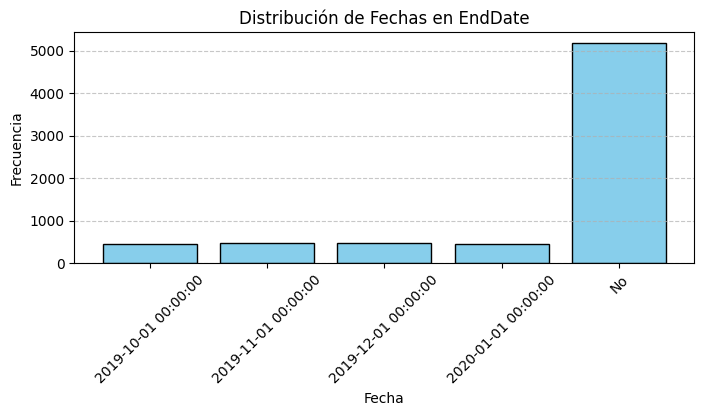

In [14]:
#Vamos a contar la frecuencia con la que aparecen cada fecha y los que aun 'no' finalizan con su servicio
date_counts = df_merged['EndDate'].value_counts().sort_index()

# Grafica de barras de los valores de la columna 'EndDate'
plt.figure(figsize=(8, 3))
plt.bar(date_counts.index, date_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribución de Fechas en EndDate')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
#numero de valores de la variable 'EnDate'
date_counts

2019-10-01 00:00:00     458
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
No                     5174
Name: EndDate, dtype: int64

podemos ver que contamos con 4 periodos en los que cancelaron el servicio y es en orden del 1 de octubre del 2019 siguendo por noviembre diciembre y enero!!

In [16]:
#convertimos los valores numericos de string a float a la columna TotalCharges
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')


In [17]:
#comprobamos que ya este hecho el cambio
df_merged['TotalCharges'].dtype

dtype('float64')

podemos ver ya los cambios realizados a nuestro analisis primario; las columnas en su formato correcto, ahora solo falta crear nuevas caracteristicas si se necesitan y trabajar con los **valores nulos!!**

# Creacion de nuevas caracteristicas

Vamos a crear una nueva columna basandonos en 'EndDate', para asi poder trabajar con nuestro modelo, sera de clasificacion binaria tomando como valor

- 0 = False
- 1 = como un True

la nueva columna se llamará 'Cancelled' haciendo referencia a la cancelación de la variable a predecir

In [18]:
# Creamos la columna 'Cancelled' basándonos en 'EndDate'
df_merged['Cancelled'] = df_merged['EndDate'].apply(lambda x: 0 if x == 'No' else 1)


# Imputacion de valores nulos

In [19]:
df_merged.isnull().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
Cancelled              0
dtype: int64

In [20]:
# Eliminar filas donde hay pocos valores nulos
df_merged = df_merged.dropna(subset=['TotalCharges'])

In [21]:
df_merged['TotalCharges'].isnull().sum()

0

eliminamos solo los valores nulos de TotalCharges al ser solo 11 filas no deberia afectar a nuestro modelo con las  trabajaremos con ellas más adelante

# Desequilibrio de clases

In [22]:
df_merged['Cancelled'].value_counts(1)

0    0.734215
1    0.265785
Name: Cancelled, dtype: float64

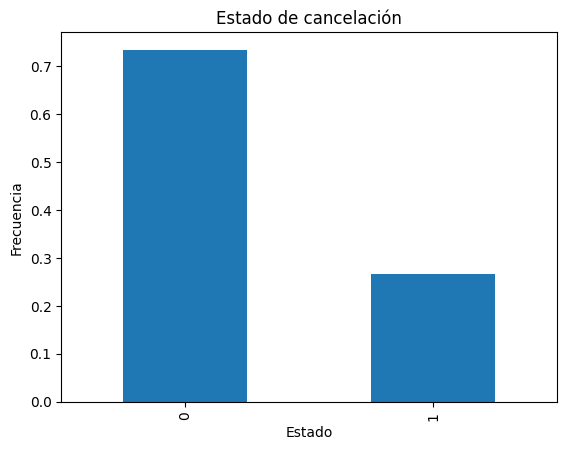

In [23]:
df_merged['Cancelled'].value_counts(1).plot(kind='bar')
plt.title('Estado de cancelación')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.show()

Podemos ver como hay un desequilibrio de las clases de nuestra variable a predecir, hay más personas las cuales no han cancelado el servicio representan el %73 de los valores, trabajaremos con el desequilibrio más adelante

# Eliminación de caracteristicas

In [24]:
#vista rapida de caracteristicas que tenemos
df_merged.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Cancelled'],
      dtype='object')

In [25]:
#Vamos a eliminar variables de nuestro dataframe que no nos aportan valor a nuestro modelo
df_merged = df_merged.drop(['customerID', 'BeginDate', 'EndDate'],axis=1)

In [26]:
df_merged.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines',
       'Cancelled'],
      dtype='object')

# one hot encoding

In [27]:
#codificaremos nuestras caracteristicas categoricas a numericas para poder trabajar con nuestro modelo
df_ohe = pd.get_dummies(df_merged, drop_first= True)

In [28]:
df_ohe.shape

(7032, 21)

se crearon 21 columnas en el nuevo dataframe en 'data_ohe' 

In [29]:
del df_merged

In [30]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         7032 non-null   float64
 1   TotalCharges                           7032 non-null   float64
 2   SeniorCitizen                          7032 non-null   int64  
 3   Cancelled                              7032 non-null   int64  
 4   Type_One year                          7032 non-null   uint8  
 5   Type_Two year                          7032 non-null   uint8  
 6   PaperlessBilling_Yes                   7032 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  7032 non-null   uint8  
 8   PaymentMethod_Electronic check         7032 non-null   uint8  
 9   PaymentMethod_Mailed check             7032 non-null   uint8  
 10  gender_Male                            7032 non-null   uint8  
 11  Part

# Separar caracteristicas y objetivos

In [31]:
X = df_ohe.drop('Cancelled', axis=1)
y = df_ohe['Cancelled']

In [32]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123456)

# Imputacion de valores con SimpleImputer

In [33]:
# Crear objeto SimpleImputer
imputer = SimpleImputer()

# Ajustar imputer'most_frequent'rain
imputer.fit(X_train)

SimpleImputer()

In [34]:
# Transforma X_train
X_train_transformed = imputer.transform(X_train)

# Transforma X_test
X_test_transformed = imputer.transform(X_test)

In [35]:
X_train.isna().sum()

MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
MultipleLines_Yes                        0
dtype: int64

In [36]:
X_test.isna().sum()

MonthlyCharges                           0
TotalCharges                             0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
OnlineSecurity_Yes                       0
OnlineBackup_Yes                         0
DeviceProtection_Yes                     0
TechSupport_Yes                          0
StreamingTV_Yes                          0
StreamingMovies_Yes                      0
MultipleLines_Yes                        0
dtype: int64

#  Escalado de datos

In [37]:
scaler = StandardScaler()
scaler.fit(X_train_transformed)
features_train = scaler.transform(X_train_transformed)
features_test = scaler.transform(X_test_transformed)

#  Modelos de aprendizaje

**mejores hiperparametros**

In [38]:
%time
from sklearn.model_selection import RandomizedSearchCV


# Modelo Random Forest con RandomSearch
rf = RandomForestClassifier(class_weight='balanced')
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
random_search_rf = RandomizedSearchCV(rf, param_grid_rf, cv=5, n_iter=10)
random_search_rf.fit(X_train_transformed, y_train)
rf_best = random_search_rf.best_estimator_

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.58 µs


In [39]:
%time
# Modelo XGBClassifier con RandomSearch

from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas usando LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Configurar XGBClassifier con las recomendaciones
xgb_clf = XGBClassifier(scale_pos_weight=10, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
    
}
random_search_xgb = RandomizedSearchCV(xgb_clf, param_grid_xgb, cv=5, n_iter=10)
random_search_xgb.fit(X_train_transformed, y_train_encoded)
xgb_best = random_search_xgb.best_estimator_

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [40]:
%time
# Modelo CatBoostClassifier con RandomSearch
cb_clf = CatBoostClassifier(class_weights=[1, 10])
param_grid_cb = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [0, 0.1, 0.5],
    'border_count': [32, 64, 128]
}
random_search_cb = RandomizedSearchCV(cb_clf, param_grid_cb, cv=5, n_iter=10)
random_search_cb.fit(X_train_transformed, y_train)
cb_best = random_search_cb.best_estimator_

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
0:	learn: 0.4269089	total: 48ms	remaining: 9.56s
1:	learn: 0.3826497	total: 50ms	remaining: 4.95s
2:	learn: 0.3720967	total: 52ms	remaining: 3.41s
3:	learn: 0.3650398	total: 53.9ms	remaining: 2.64s
4:	learn: 0.3578814	total: 55.9ms	remaining: 2.18s
5:	learn: 0.3539532	total: 57.9ms	remaining: 1.87s
6:	learn: 0.3504435	total: 59.9ms	remaining: 1.65s
7:	learn: 0.3440970	total: 61.9ms	remaining: 1.48s
8:	learn: 0.3399749	total: 63.8ms	remaining: 1.35s
9:	learn: 0.3350831	total: 65.8ms	remaining: 1.25s
10:	learn: 0.3305908	total: 67.8ms	remaining: 1.16s
11:	learn: 0.3259719	total: 69.8ms	remaining: 1.09s
12:	learn: 0.3222634	total: 71.7ms	remaining: 1.03s
13:	learn: 0.3175772	total: 73.7ms	remaining: 980ms
14:	learn: 0.3137189	total: 75.8ms	remaining: 934ms
15:	learn: 0.3109224	total: 77.8ms	remaining: 895ms
16:	learn: 0.3062967	total: 79.9ms	remaining: 860ms
17:	learn: 0.3024987	total: 81.9ms	remaining: 828ms
18:	learn: 0.295

0:	learn: 0.4285136	total: 2.05ms	remaining: 408ms
1:	learn: 0.3979333	total: 3.27ms	remaining: 323ms
2:	learn: 0.3824689	total: 5.24ms	remaining: 344ms
3:	learn: 0.3735774	total: 7.26ms	remaining: 356ms
4:	learn: 0.3625144	total: 9.24ms	remaining: 360ms
5:	learn: 0.3559747	total: 11.2ms	remaining: 363ms
6:	learn: 0.3511176	total: 13.2ms	remaining: 363ms
7:	learn: 0.3466297	total: 15.2ms	remaining: 364ms
8:	learn: 0.3437339	total: 17.1ms	remaining: 364ms
9:	learn: 0.3359862	total: 19.2ms	remaining: 364ms
10:	learn: 0.3303562	total: 21.2ms	remaining: 364ms
11:	learn: 0.3257583	total: 23.2ms	remaining: 363ms
12:	learn: 0.3179768	total: 25.2ms	remaining: 363ms
13:	learn: 0.3135345	total: 27.2ms	remaining: 361ms
14:	learn: 0.3065946	total: 29.2ms	remaining: 360ms
15:	learn: 0.3025974	total: 31.2ms	remaining: 359ms
16:	learn: 0.2986047	total: 33.3ms	remaining: 359ms
17:	learn: 0.2932191	total: 35.3ms	remaining: 357ms
18:	learn: 0.2882932	total: 37.3ms	remaining: 355ms
19:	learn: 0.2852258	t

189:	learn: 0.0699730	total: 396ms	remaining: 20.9ms
190:	learn: 0.0694375	total: 398ms	remaining: 18.8ms
191:	learn: 0.0690609	total: 400ms	remaining: 16.7ms
192:	learn: 0.0688607	total: 402ms	remaining: 14.6ms
193:	learn: 0.0679777	total: 404ms	remaining: 12.5ms
194:	learn: 0.0677972	total: 406ms	remaining: 10.4ms
195:	learn: 0.0672426	total: 408ms	remaining: 8.33ms
196:	learn: 0.0670279	total: 410ms	remaining: 6.25ms
197:	learn: 0.0665400	total: 412ms	remaining: 4.17ms
198:	learn: 0.0659715	total: 414ms	remaining: 2.08ms
199:	learn: 0.0653620	total: 416ms	remaining: 0us
0:	learn: 0.4273777	total: 2.01ms	remaining: 400ms
1:	learn: 0.3901485	total: 4.19ms	remaining: 415ms
2:	learn: 0.3711797	total: 6.17ms	remaining: 405ms
3:	learn: 0.3609641	total: 8.19ms	remaining: 401ms
4:	learn: 0.3564269	total: 10.2ms	remaining: 397ms
5:	learn: 0.3507086	total: 12.2ms	remaining: 395ms
6:	learn: 0.3489039	total: 13.9ms	remaining: 382ms
7:	learn: 0.3453750	total: 16ms	remaining: 384ms
8:	learn: 0.34

0:	learn: 0.4233319	total: 1.98ms	remaining: 394ms
1:	learn: 0.3835355	total: 4.27ms	remaining: 423ms
2:	learn: 0.3708897	total: 6.24ms	remaining: 410ms
3:	learn: 0.3629939	total: 8.37ms	remaining: 410ms
4:	learn: 0.3566410	total: 10.3ms	remaining: 404ms
5:	learn: 0.3486623	total: 12.3ms	remaining: 399ms
6:	learn: 0.3447646	total: 14.3ms	remaining: 395ms
7:	learn: 0.3404701	total: 16.3ms	remaining: 391ms
8:	learn: 0.3348848	total: 18.3ms	remaining: 388ms
9:	learn: 0.3269296	total: 20.3ms	remaining: 386ms
10:	learn: 0.3240267	total: 22.3ms	remaining: 383ms
11:	learn: 0.3209195	total: 24.4ms	remaining: 382ms
12:	learn: 0.3179061	total: 26.3ms	remaining: 379ms
13:	learn: 0.3136125	total: 28.4ms	remaining: 377ms
14:	learn: 0.3104496	total: 30.4ms	remaining: 375ms
15:	learn: 0.3067878	total: 32.4ms	remaining: 373ms
16:	learn: 0.3033333	total: 34.4ms	remaining: 371ms
17:	learn: 0.3016311	total: 36.5ms	remaining: 369ms
18:	learn: 0.2983460	total: 38.5ms	remaining: 367ms
19:	learn: 0.2934383	t

192:	learn: 0.0668945	total: 396ms	remaining: 14.4ms
193:	learn: 0.0663773	total: 398ms	remaining: 12.3ms
194:	learn: 0.0660557	total: 400ms	remaining: 10.3ms
195:	learn: 0.0652195	total: 402ms	remaining: 8.21ms
196:	learn: 0.0647176	total: 404ms	remaining: 6.16ms
197:	learn: 0.0643768	total: 407ms	remaining: 4.11ms
198:	learn: 0.0639542	total: 409ms	remaining: 2.05ms
199:	learn: 0.0636056	total: 411ms	remaining: 0us
0:	learn: 0.4236399	total: 1.96ms	remaining: 390ms
1:	learn: 0.3777244	total: 3.98ms	remaining: 394ms
2:	learn: 0.3616314	total: 5.89ms	remaining: 387ms
3:	learn: 0.3546423	total: 8.04ms	remaining: 394ms
4:	learn: 0.3461903	total: 9.99ms	remaining: 390ms
5:	learn: 0.3400661	total: 12ms	remaining: 387ms
6:	learn: 0.3349891	total: 13.9ms	remaining: 384ms
7:	learn: 0.3298257	total: 15.9ms	remaining: 382ms
8:	learn: 0.3272554	total: 17.9ms	remaining: 380ms
9:	learn: 0.3243082	total: 19.9ms	remaining: 378ms
10:	learn: 0.3197906	total: 22ms	remaining: 378ms
11:	learn: 0.3152556	

0:	learn: 0.4307708	total: 1.34ms	remaining: 65.7ms
1:	learn: 0.3999124	total: 2.79ms	remaining: 67.1ms
2:	learn: 0.3860688	total: 3.93ms	remaining: 61.6ms
3:	learn: 0.3811192	total: 5.05ms	remaining: 58.1ms
4:	learn: 0.3792153	total: 6.23ms	remaining: 56ms
5:	learn: 0.3770718	total: 7.35ms	remaining: 53.9ms
6:	learn: 0.3725537	total: 8.44ms	remaining: 51.8ms
7:	learn: 0.3714452	total: 9.63ms	remaining: 50.5ms
8:	learn: 0.3683120	total: 10.8ms	remaining: 49ms
9:	learn: 0.3645192	total: 12ms	remaining: 48ms
10:	learn: 0.3620197	total: 13.3ms	remaining: 47ms
11:	learn: 0.3574126	total: 14.4ms	remaining: 45.5ms
12:	learn: 0.3541657	total: 15.5ms	remaining: 44.2ms
13:	learn: 0.3525260	total: 16.6ms	remaining: 42.7ms
14:	learn: 0.3502396	total: 17.8ms	remaining: 41.5ms
15:	learn: 0.3485623	total: 18.9ms	remaining: 40.2ms
16:	learn: 0.3461373	total: 20.1ms	remaining: 39ms
17:	learn: 0.3436948	total: 21.5ms	remaining: 38.2ms
18:	learn: 0.3417841	total: 22.6ms	remaining: 36.8ms
19:	learn: 0.33

28:	learn: 0.3260701	total: 34.5ms	remaining: 25ms
29:	learn: 0.3246185	total: 35.8ms	remaining: 23.8ms
30:	learn: 0.3237546	total: 37.1ms	remaining: 22.7ms
31:	learn: 0.3236814	total: 38.1ms	remaining: 21.5ms
32:	learn: 0.3212449	total: 39.5ms	remaining: 20.4ms
33:	learn: 0.3199222	total: 40.6ms	remaining: 19.1ms
34:	learn: 0.3187038	total: 41.7ms	remaining: 17.9ms
35:	learn: 0.3179863	total: 42.8ms	remaining: 16.7ms
36:	learn: 0.3172913	total: 44.2ms	remaining: 15.5ms
37:	learn: 0.3160642	total: 45.2ms	remaining: 14.3ms
38:	learn: 0.3151590	total: 46.4ms	remaining: 13.1ms
39:	learn: 0.3139176	total: 47.5ms	remaining: 11.9ms
40:	learn: 0.3131652	total: 48.6ms	remaining: 10.7ms
41:	learn: 0.3114192	total: 49.9ms	remaining: 9.51ms
42:	learn: 0.3108723	total: 51.1ms	remaining: 8.33ms
43:	learn: 0.3095806	total: 52.5ms	remaining: 7.16ms
44:	learn: 0.3083199	total: 53.9ms	remaining: 5.99ms
45:	learn: 0.3076831	total: 55.3ms	remaining: 4.81ms
46:	learn: 0.3066572	total: 56.7ms	remaining: 3.

185:	learn: 0.2384423	total: 245ms	remaining: 18.4ms
186:	learn: 0.2376395	total: 246ms	remaining: 17.1ms
187:	learn: 0.2372744	total: 247ms	remaining: 15.8ms
188:	learn: 0.2367272	total: 249ms	remaining: 14.5ms
189:	learn: 0.2364892	total: 250ms	remaining: 13.2ms
190:	learn: 0.2361405	total: 255ms	remaining: 12ms
191:	learn: 0.2358469	total: 257ms	remaining: 10.7ms
192:	learn: 0.2355275	total: 258ms	remaining: 9.36ms
193:	learn: 0.2350582	total: 259ms	remaining: 8.02ms
194:	learn: 0.2346452	total: 260ms	remaining: 6.68ms
195:	learn: 0.2344598	total: 262ms	remaining: 5.34ms
196:	learn: 0.2342151	total: 263ms	remaining: 4.01ms
197:	learn: 0.2338764	total: 264ms	remaining: 2.67ms
198:	learn: 0.2334062	total: 266ms	remaining: 1.34ms
199:	learn: 0.2332057	total: 267ms	remaining: 0us
0:	learn: 0.4955552	total: 1.29ms	remaining: 257ms
1:	learn: 0.4287171	total: 2.5ms	remaining: 248ms
2:	learn: 0.4080422	total: 3.77ms	remaining: 248ms
3:	learn: 0.3888884	total: 5.01ms	remaining: 246ms
4:	lear

184:	learn: 0.2427321	total: 240ms	remaining: 19.4ms
185:	learn: 0.2423974	total: 241ms	remaining: 18.2ms
186:	learn: 0.2419627	total: 243ms	remaining: 16.9ms
187:	learn: 0.2412685	total: 248ms	remaining: 15.8ms
188:	learn: 0.2410114	total: 250ms	remaining: 14.5ms
189:	learn: 0.2404509	total: 251ms	remaining: 13.2ms
190:	learn: 0.2396403	total: 252ms	remaining: 11.9ms
191:	learn: 0.2393013	total: 254ms	remaining: 10.6ms
192:	learn: 0.2390637	total: 255ms	remaining: 9.25ms
193:	learn: 0.2385371	total: 256ms	remaining: 7.92ms
194:	learn: 0.2381710	total: 257ms	remaining: 6.6ms
195:	learn: 0.2378040	total: 259ms	remaining: 5.28ms
196:	learn: 0.2375170	total: 260ms	remaining: 3.96ms
197:	learn: 0.2371604	total: 261ms	remaining: 2.64ms
198:	learn: 0.2360374	total: 262ms	remaining: 1.32ms
199:	learn: 0.2358371	total: 264ms	remaining: 0us
0:	learn: 0.4951725	total: 1.34ms	remaining: 268ms
1:	learn: 0.4410648	total: 2.72ms	remaining: 269ms
2:	learn: 0.4097811	total: 4.05ms	remaining: 266ms
3:	

183:	learn: 0.2403929	total: 237ms	remaining: 20.6ms
184:	learn: 0.2400900	total: 238ms	remaining: 19.3ms
185:	learn: 0.2397466	total: 240ms	remaining: 18ms
186:	learn: 0.2395016	total: 241ms	remaining: 16.8ms
187:	learn: 0.2389733	total: 242ms	remaining: 15.5ms
188:	learn: 0.2387257	total: 244ms	remaining: 14.2ms
189:	learn: 0.2386021	total: 245ms	remaining: 12.9ms
190:	learn: 0.2382136	total: 246ms	remaining: 11.6ms
191:	learn: 0.2381333	total: 248ms	remaining: 10.3ms
192:	learn: 0.2376246	total: 249ms	remaining: 9.03ms
193:	learn: 0.2370223	total: 250ms	remaining: 7.74ms
194:	learn: 0.2367009	total: 252ms	remaining: 6.45ms
195:	learn: 0.2364751	total: 253ms	remaining: 5.16ms
196:	learn: 0.2361349	total: 254ms	remaining: 3.87ms
197:	learn: 0.2359033	total: 255ms	remaining: 2.58ms
198:	learn: 0.2354173	total: 257ms	remaining: 1.29ms
199:	learn: 0.2351261	total: 258ms	remaining: 0us
0:	learn: 0.4911131	total: 1.28ms	remaining: 254ms
1:	learn: 0.4437168	total: 2.49ms	remaining: 247ms
2:

182:	learn: 0.2439589	total: 238ms	remaining: 22.1ms
183:	learn: 0.2432526	total: 240ms	remaining: 20.9ms
184:	learn: 0.2426859	total: 241ms	remaining: 19.6ms
185:	learn: 0.2424388	total: 243ms	remaining: 18.3ms
186:	learn: 0.2422926	total: 244ms	remaining: 17ms
187:	learn: 0.2418611	total: 245ms	remaining: 15.7ms
188:	learn: 0.2415406	total: 247ms	remaining: 14.4ms
189:	learn: 0.2413405	total: 248ms	remaining: 13.1ms
190:	learn: 0.2409700	total: 249ms	remaining: 11.8ms
191:	learn: 0.2407408	total: 251ms	remaining: 10.5ms
192:	learn: 0.2404411	total: 252ms	remaining: 9.15ms
193:	learn: 0.2400502	total: 254ms	remaining: 7.84ms
194:	learn: 0.2395343	total: 255ms	remaining: 6.53ms
195:	learn: 0.2387235	total: 256ms	remaining: 5.23ms
196:	learn: 0.2382647	total: 257ms	remaining: 3.92ms
197:	learn: 0.2377570	total: 259ms	remaining: 2.61ms
198:	learn: 0.2375263	total: 260ms	remaining: 1.31ms
199:	learn: 0.2372928	total: 261ms	remaining: 0us
0:	learn: 0.4903169	total: 1.31ms	remaining: 261ms


177:	learn: 0.2385582	total: 236ms	remaining: 29.2ms
178:	learn: 0.2379331	total: 238ms	remaining: 27.9ms
179:	learn: 0.2374823	total: 239ms	remaining: 26.6ms
180:	learn: 0.2373420	total: 241ms	remaining: 25.3ms
181:	learn: 0.2369288	total: 242ms	remaining: 23.9ms
182:	learn: 0.2366287	total: 243ms	remaining: 22.6ms
183:	learn: 0.2358805	total: 245ms	remaining: 21.3ms
184:	learn: 0.2355073	total: 246ms	remaining: 19.9ms
185:	learn: 0.2352236	total: 247ms	remaining: 18.6ms
186:	learn: 0.2347363	total: 249ms	remaining: 17.3ms
187:	learn: 0.2344422	total: 250ms	remaining: 15.9ms
188:	learn: 0.2330596	total: 251ms	remaining: 14.6ms
189:	learn: 0.2322184	total: 253ms	remaining: 13.3ms
190:	learn: 0.2318309	total: 254ms	remaining: 12ms
191:	learn: 0.2313714	total: 255ms	remaining: 10.6ms
192:	learn: 0.2311169	total: 256ms	remaining: 9.3ms
193:	learn: 0.2308587	total: 258ms	remaining: 7.97ms
194:	learn: 0.2306533	total: 259ms	remaining: 6.64ms
195:	learn: 0.2299150	total: 260ms	remaining: 5.3

51:	learn: 0.2917478	total: 203ms	remaining: 187ms
52:	learn: 0.2908205	total: 207ms	remaining: 184ms
53:	learn: 0.2881570	total: 211ms	remaining: 180ms
54:	learn: 0.2875359	total: 215ms	remaining: 176ms
55:	learn: 0.2873886	total: 217ms	remaining: 170ms
56:	learn: 0.2850980	total: 221ms	remaining: 167ms
57:	learn: 0.2850089	total: 223ms	remaining: 161ms
58:	learn: 0.2848283	total: 225ms	remaining: 156ms
59:	learn: 0.2833809	total: 229ms	remaining: 153ms
60:	learn: 0.2829922	total: 233ms	remaining: 149ms
61:	learn: 0.2829505	total: 234ms	remaining: 144ms
62:	learn: 0.2815713	total: 238ms	remaining: 140ms
63:	learn: 0.2803360	total: 242ms	remaining: 136ms
64:	learn: 0.2782188	total: 247ms	remaining: 133ms
65:	learn: 0.2777469	total: 251ms	remaining: 129ms
66:	learn: 0.2771179	total: 255ms	remaining: 126ms
67:	learn: 0.2767588	total: 259ms	remaining: 122ms
68:	learn: 0.2753067	total: 263ms	remaining: 118ms
69:	learn: 0.2752486	total: 265ms	remaining: 114ms
70:	learn: 0.2748810	total: 269

14:	learn: 0.3578944	total: 62.1ms	remaining: 352ms
15:	learn: 0.3518605	total: 66.5ms	remaining: 349ms
16:	learn: 0.3485766	total: 70.9ms	remaining: 346ms
17:	learn: 0.3477388	total: 72ms	remaining: 328ms
18:	learn: 0.3443207	total: 76.3ms	remaining: 325ms
19:	learn: 0.3409652	total: 80.4ms	remaining: 322ms
20:	learn: 0.3382104	total: 84.6ms	remaining: 318ms
21:	learn: 0.3347696	total: 88.8ms	remaining: 315ms
22:	learn: 0.3329489	total: 92.9ms	remaining: 311ms
23:	learn: 0.3306224	total: 97ms	remaining: 307ms
24:	learn: 0.3282428	total: 101ms	remaining: 303ms
25:	learn: 0.3270296	total: 105ms	remaining: 299ms
26:	learn: 0.3260932	total: 110ms	remaining: 297ms
27:	learn: 0.3237063	total: 114ms	remaining: 293ms
28:	learn: 0.3215049	total: 118ms	remaining: 290ms
29:	learn: 0.3209198	total: 123ms	remaining: 286ms
30:	learn: 0.3193925	total: 127ms	remaining: 282ms
31:	learn: 0.3182853	total: 131ms	remaining: 278ms
32:	learn: 0.3171043	total: 135ms	remaining: 274ms
33:	learn: 0.3159231	tota

0:	learn: 0.6384532	total: 1.3ms	remaining: 128ms
1:	learn: 0.5959731	total: 2.94ms	remaining: 144ms
2:	learn: 0.5557827	total: 4.28ms	remaining: 139ms
3:	learn: 0.5306739	total: 5.56ms	remaining: 133ms
4:	learn: 0.5113671	total: 6.94ms	remaining: 132ms
5:	learn: 0.4918863	total: 8.21ms	remaining: 129ms
6:	learn: 0.4702658	total: 9.47ms	remaining: 126ms
7:	learn: 0.4581816	total: 10.7ms	remaining: 123ms
8:	learn: 0.4461901	total: 12.1ms	remaining: 122ms
9:	learn: 0.4380828	total: 13.4ms	remaining: 121ms
10:	learn: 0.4305480	total: 14.7ms	remaining: 119ms
11:	learn: 0.4206846	total: 16ms	remaining: 117ms
12:	learn: 0.4149563	total: 17.4ms	remaining: 116ms
13:	learn: 0.4085676	total: 18.7ms	remaining: 115ms
14:	learn: 0.4046701	total: 20ms	remaining: 113ms
15:	learn: 0.4019798	total: 21.3ms	remaining: 112ms
16:	learn: 0.3996724	total: 22.5ms	remaining: 110ms
17:	learn: 0.3967484	total: 23.8ms	remaining: 108ms
18:	learn: 0.3933363	total: 25ms	remaining: 107ms
19:	learn: 0.3910035	total: 2

0:	learn: 0.6395214	total: 1.32ms	remaining: 131ms
1:	learn: 0.5973644	total: 2.97ms	remaining: 146ms
2:	learn: 0.5575942	total: 4.36ms	remaining: 141ms
3:	learn: 0.5321094	total: 5.68ms	remaining: 136ms
4:	learn: 0.5075202	total: 6.95ms	remaining: 132ms
5:	learn: 0.4853650	total: 8.22ms	remaining: 129ms
6:	learn: 0.4677970	total: 9.61ms	remaining: 128ms
7:	learn: 0.4556438	total: 10.9ms	remaining: 125ms
8:	learn: 0.4453222	total: 12.3ms	remaining: 124ms
9:	learn: 0.4332856	total: 13.5ms	remaining: 122ms
10:	learn: 0.4264404	total: 14.8ms	remaining: 119ms
11:	learn: 0.4203175	total: 16ms	remaining: 117ms
12:	learn: 0.4135603	total: 17.2ms	remaining: 115ms
13:	learn: 0.4075925	total: 18.6ms	remaining: 114ms
14:	learn: 0.4023422	total: 19.8ms	remaining: 112ms
15:	learn: 0.3981520	total: 21.1ms	remaining: 111ms
16:	learn: 0.3957598	total: 22.3ms	remaining: 109ms
17:	learn: 0.3925345	total: 23.6ms	remaining: 108ms
18:	learn: 0.3901330	total: 24.8ms	remaining: 106ms
19:	learn: 0.3870232	tot

0:	learn: 0.6381863	total: 1.27ms	remaining: 125ms
1:	learn: 0.5892666	total: 2.57ms	remaining: 126ms
2:	learn: 0.5521789	total: 3.83ms	remaining: 124ms
3:	learn: 0.5185180	total: 5.11ms	remaining: 123ms
4:	learn: 0.4999793	total: 6.18ms	remaining: 118ms
5:	learn: 0.4828666	total: 7.45ms	remaining: 117ms
6:	learn: 0.4669297	total: 8.66ms	remaining: 115ms
7:	learn: 0.4516138	total: 9.91ms	remaining: 114ms
8:	learn: 0.4416578	total: 11.2ms	remaining: 113ms
9:	learn: 0.4323115	total: 12.4ms	remaining: 112ms
10:	learn: 0.4260339	total: 13.6ms	remaining: 110ms
11:	learn: 0.4169935	total: 14.9ms	remaining: 109ms
12:	learn: 0.4114269	total: 16.3ms	remaining: 109ms
13:	learn: 0.4065939	total: 17.5ms	remaining: 107ms
14:	learn: 0.4019563	total: 18.8ms	remaining: 106ms
15:	learn: 0.3991145	total: 20ms	remaining: 105ms
16:	learn: 0.3965614	total: 21.2ms	remaining: 104ms
17:	learn: 0.3929395	total: 22.5ms	remaining: 103ms
18:	learn: 0.3903829	total: 23.8ms	remaining: 101ms
19:	learn: 0.3877999	tot

0:	learn: 0.4114685	total: 4.08ms	remaining: 200ms
1:	learn: 0.3641977	total: 8.09ms	remaining: 194ms
2:	learn: 0.3398536	total: 11.9ms	remaining: 187ms
3:	learn: 0.3341407	total: 15.7ms	remaining: 180ms
4:	learn: 0.3224065	total: 19.5ms	remaining: 176ms
5:	learn: 0.3131292	total: 23.3ms	remaining: 171ms
6:	learn: 0.3083988	total: 27.2ms	remaining: 167ms
7:	learn: 0.3024085	total: 31ms	remaining: 163ms
8:	learn: 0.2945591	total: 34.8ms	remaining: 159ms
9:	learn: 0.2825302	total: 38.8ms	remaining: 155ms
10:	learn: 0.2762326	total: 42.5ms	remaining: 151ms
11:	learn: 0.2669198	total: 46.4ms	remaining: 147ms
12:	learn: 0.2602255	total: 50.1ms	remaining: 143ms
13:	learn: 0.2512461	total: 54ms	remaining: 139ms
14:	learn: 0.2421668	total: 57.7ms	remaining: 135ms
15:	learn: 0.2381504	total: 61.6ms	remaining: 131ms
16:	learn: 0.2334667	total: 65.5ms	remaining: 127ms
17:	learn: 0.2299714	total: 69.4ms	remaining: 123ms
18:	learn: 0.2210705	total: 73.4ms	remaining: 120ms
19:	learn: 0.2152117	total

0:	learn: 0.4285136	total: 2.05ms	remaining: 203ms
1:	learn: 0.3870496	total: 4.31ms	remaining: 211ms
2:	learn: 0.3764872	total: 6.34ms	remaining: 205ms
3:	learn: 0.3673728	total: 8.31ms	remaining: 199ms
4:	learn: 0.3561521	total: 10.3ms	remaining: 197ms
5:	learn: 0.3543370	total: 12.2ms	remaining: 191ms
6:	learn: 0.3478756	total: 14.1ms	remaining: 187ms
7:	learn: 0.3423800	total: 16.2ms	remaining: 186ms
8:	learn: 0.3364674	total: 18.1ms	remaining: 183ms
9:	learn: 0.3296825	total: 20.2ms	remaining: 182ms
10:	learn: 0.3247843	total: 22.2ms	remaining: 179ms
11:	learn: 0.3177296	total: 24.2ms	remaining: 177ms
12:	learn: 0.3131231	total: 26.2ms	remaining: 175ms
13:	learn: 0.3073997	total: 28.2ms	remaining: 174ms
14:	learn: 0.3032914	total: 30.3ms	remaining: 172ms
15:	learn: 0.3001222	total: 32.3ms	remaining: 170ms
16:	learn: 0.2947014	total: 34.3ms	remaining: 167ms
17:	learn: 0.2927263	total: 36.2ms	remaining: 165ms
18:	learn: 0.2873270	total: 38.1ms	remaining: 163ms
19:	learn: 0.2843759	t

0:	learn: 0.4233312	total: 2.58ms	remaining: 256ms
1:	learn: 0.3835012	total: 7.03ms	remaining: 344ms
2:	learn: 0.3681068	total: 9.17ms	remaining: 297ms
3:	learn: 0.3646041	total: 10.8ms	remaining: 259ms
4:	learn: 0.3611297	total: 13ms	remaining: 247ms
5:	learn: 0.3557594	total: 15.4ms	remaining: 242ms
6:	learn: 0.3517327	total: 17.7ms	remaining: 235ms
7:	learn: 0.3478205	total: 20.1ms	remaining: 231ms
8:	learn: 0.3417377	total: 22.2ms	remaining: 225ms
9:	learn: 0.3390248	total: 24.1ms	remaining: 217ms
10:	learn: 0.3312110	total: 26.4ms	remaining: 214ms
11:	learn: 0.3273900	total: 28.9ms	remaining: 212ms
12:	learn: 0.3240899	total: 31.4ms	remaining: 210ms
13:	learn: 0.3190712	total: 33.6ms	remaining: 206ms
14:	learn: 0.3129456	total: 36ms	remaining: 204ms
15:	learn: 0.3090048	total: 38.2ms	remaining: 201ms
16:	learn: 0.3045360	total: 40.2ms	remaining: 196ms
17:	learn: 0.2993803	total: 42.3ms	remaining: 193ms
18:	learn: 0.2953246	total: 44.3ms	remaining: 189ms
19:	learn: 0.2897485	total

0:	learn: 0.4161490	total: 4.3ms	remaining: 211ms
1:	learn: 0.3683249	total: 8.74ms	remaining: 210ms
2:	learn: 0.3473208	total: 12.8ms	remaining: 201ms
3:	learn: 0.3361978	total: 17.1ms	remaining: 196ms
4:	learn: 0.3184878	total: 21.1ms	remaining: 190ms
5:	learn: 0.3093419	total: 25.2ms	remaining: 185ms
6:	learn: 0.3045237	total: 29.4ms	remaining: 181ms
7:	learn: 0.2945954	total: 33.7ms	remaining: 177ms
8:	learn: 0.2887017	total: 37.7ms	remaining: 172ms
9:	learn: 0.2719095	total: 41.9ms	remaining: 168ms
10:	learn: 0.2627643	total: 46ms	remaining: 163ms
11:	learn: 0.2557997	total: 50.1ms	remaining: 159ms
12:	learn: 0.2441264	total: 54.1ms	remaining: 154ms
13:	learn: 0.2372428	total: 58.3ms	remaining: 150ms
14:	learn: 0.2295086	total: 62.7ms	remaining: 146ms
15:	learn: 0.2264128	total: 67ms	remaining: 142ms
16:	learn: 0.2210613	total: 71.4ms	remaining: 139ms
17:	learn: 0.2146097	total: 75.6ms	remaining: 134ms
18:	learn: 0.2079101	total: 79.7ms	remaining: 130ms
19:	learn: 0.2043232	total:

16:	learn: 0.2261372	total: 68.4ms	remaining: 133ms
17:	learn: 0.2230470	total: 72.9ms	remaining: 130ms
18:	learn: 0.2184514	total: 77.1ms	remaining: 126ms
19:	learn: 0.2127928	total: 81.4ms	remaining: 122ms
20:	learn: 0.2095481	total: 85.7ms	remaining: 118ms
21:	learn: 0.2058872	total: 90ms	remaining: 115ms
22:	learn: 0.2028966	total: 94ms	remaining: 110ms
23:	learn: 0.2010226	total: 97.9ms	remaining: 106ms
24:	learn: 0.1954569	total: 102ms	remaining: 102ms
25:	learn: 0.1898651	total: 106ms	remaining: 97.8ms
26:	learn: 0.1864682	total: 110ms	remaining: 93.8ms
27:	learn: 0.1805068	total: 114ms	remaining: 89.8ms
28:	learn: 0.1767269	total: 118ms	remaining: 85.8ms
29:	learn: 0.1729375	total: 122ms	remaining: 81.6ms
30:	learn: 0.1693182	total: 126ms	remaining: 77.5ms
31:	learn: 0.1633069	total: 131ms	remaining: 73.6ms
32:	learn: 0.1585311	total: 135ms	remaining: 69.5ms
33:	learn: 0.1543937	total: 139ms	remaining: 65.4ms
34:	learn: 0.1488159	total: 143ms	remaining: 61.3ms
35:	learn: 0.1420

0:	learn: 0.4798217	total: 2.02ms	remaining: 200ms
1:	learn: 0.4093243	total: 4.16ms	remaining: 204ms
2:	learn: 0.4043124	total: 5.16ms	remaining: 167ms
3:	learn: 0.3832129	total: 7.03ms	remaining: 169ms
4:	learn: 0.3732911	total: 8.93ms	remaining: 170ms
5:	learn: 0.3687636	total: 10.6ms	remaining: 167ms
6:	learn: 0.3645144	total: 12.5ms	remaining: 166ms
7:	learn: 0.3592135	total: 14.2ms	remaining: 164ms
8:	learn: 0.3545543	total: 16.2ms	remaining: 164ms
9:	learn: 0.3487734	total: 18.1ms	remaining: 163ms
10:	learn: 0.3443546	total: 20ms	remaining: 161ms
11:	learn: 0.3417834	total: 21.8ms	remaining: 160ms
12:	learn: 0.3386233	total: 23.7ms	remaining: 158ms
13:	learn: 0.3354331	total: 25.5ms	remaining: 157ms
14:	learn: 0.3325255	total: 27.4ms	remaining: 155ms
15:	learn: 0.3311882	total: 29.2ms	remaining: 153ms
16:	learn: 0.3274394	total: 31ms	remaining: 151ms
17:	learn: 0.3247656	total: 32.8ms	remaining: 150ms
18:	learn: 0.3221325	total: 34.7ms	remaining: 148ms
19:	learn: 0.3190950	total

0:	learn: 0.4741890	total: 2.19ms	remaining: 217ms
1:	learn: 0.4054721	total: 4.3ms	remaining: 211ms
2:	learn: 0.4003319	total: 5.49ms	remaining: 178ms
3:	learn: 0.3779972	total: 7.56ms	remaining: 181ms
4:	learn: 0.3671547	total: 9.85ms	remaining: 187ms
5:	learn: 0.3645338	total: 11.1ms	remaining: 173ms
6:	learn: 0.3572497	total: 12.9ms	remaining: 172ms
7:	learn: 0.3521401	total: 14.8ms	remaining: 170ms
8:	learn: 0.3506893	total: 16.6ms	remaining: 167ms
9:	learn: 0.3488061	total: 18.3ms	remaining: 165ms
10:	learn: 0.3468490	total: 20ms	remaining: 162ms
11:	learn: 0.3419348	total: 21.8ms	remaining: 160ms
12:	learn: 0.3382965	total: 23.7ms	remaining: 159ms
13:	learn: 0.3336774	total: 25.6ms	remaining: 158ms
14:	learn: 0.3311888	total: 27.5ms	remaining: 156ms
15:	learn: 0.3273137	total: 29.3ms	remaining: 154ms
16:	learn: 0.3251538	total: 31.2ms	remaining: 152ms
17:	learn: 0.3238083	total: 33ms	remaining: 151ms
18:	learn: 0.3200882	total: 34.9ms	remaining: 149ms
19:	learn: 0.3174321	total:

0:	learn: 0.4768382	total: 1.98ms	remaining: 393ms
1:	learn: 0.4159360	total: 3.59ms	remaining: 356ms
2:	learn: 0.3866926	total: 5.47ms	remaining: 360ms
3:	learn: 0.3748926	total: 7.45ms	remaining: 365ms
4:	learn: 0.3663750	total: 9.42ms	remaining: 367ms
5:	learn: 0.3632689	total: 11.2ms	remaining: 361ms
6:	learn: 0.3587995	total: 13.1ms	remaining: 360ms
7:	learn: 0.3557041	total: 15.1ms	remaining: 363ms
8:	learn: 0.3531808	total: 17ms	remaining: 361ms
9:	learn: 0.3489021	total: 18.9ms	remaining: 359ms
10:	learn: 0.3471518	total: 20.7ms	remaining: 355ms
11:	learn: 0.3447940	total: 22.6ms	remaining: 353ms
12:	learn: 0.3428605	total: 24.4ms	remaining: 351ms
13:	learn: 0.3394219	total: 26.3ms	remaining: 349ms
14:	learn: 0.3376469	total: 28.1ms	remaining: 346ms
15:	learn: 0.3357847	total: 30ms	remaining: 345ms
16:	learn: 0.3311632	total: 31.8ms	remaining: 343ms
17:	learn: 0.3285779	total: 33.8ms	remaining: 341ms
18:	learn: 0.3264764	total: 35.7ms	remaining: 340ms
19:	learn: 0.3224103	total

0:	learn: 0.4798217	total: 1.93ms	remaining: 384ms
1:	learn: 0.4093243	total: 4.21ms	remaining: 417ms
2:	learn: 0.4043124	total: 5.2ms	remaining: 342ms
3:	learn: 0.3832129	total: 7.11ms	remaining: 348ms
4:	learn: 0.3732911	total: 8.95ms	remaining: 349ms
5:	learn: 0.3687636	total: 10.6ms	remaining: 344ms
6:	learn: 0.3645144	total: 12.5ms	remaining: 345ms
7:	learn: 0.3592135	total: 14.2ms	remaining: 342ms
8:	learn: 0.3545543	total: 16.2ms	remaining: 343ms
9:	learn: 0.3487734	total: 18ms	remaining: 342ms
10:	learn: 0.3443546	total: 19.9ms	remaining: 342ms
11:	learn: 0.3417834	total: 21.7ms	remaining: 340ms
12:	learn: 0.3386233	total: 23.6ms	remaining: 339ms
13:	learn: 0.3354331	total: 25.4ms	remaining: 338ms
14:	learn: 0.3325255	total: 27.3ms	remaining: 337ms
15:	learn: 0.3311882	total: 29.1ms	remaining: 334ms
16:	learn: 0.3274394	total: 30.9ms	remaining: 333ms
17:	learn: 0.3247656	total: 32.7ms	remaining: 331ms
18:	learn: 0.3221325	total: 34.6ms	remaining: 330ms
19:	learn: 0.3190950	tota

0:	learn: 0.4771555	total: 1.99ms	remaining: 395ms
1:	learn: 0.4088395	total: 4.1ms	remaining: 406ms
2:	learn: 0.4038210	total: 5.06ms	remaining: 333ms
3:	learn: 0.3786039	total: 6.94ms	remaining: 340ms
4:	learn: 0.3683747	total: 8.75ms	remaining: 341ms
5:	learn: 0.3628645	total: 10.6ms	remaining: 343ms
6:	learn: 0.3569129	total: 12.4ms	remaining: 341ms
7:	learn: 0.3519633	total: 14.2ms	remaining: 340ms
8:	learn: 0.3486974	total: 16ms	remaining: 339ms
9:	learn: 0.3462407	total: 17.6ms	remaining: 335ms
10:	learn: 0.3406315	total: 19.5ms	remaining: 334ms
11:	learn: 0.3373978	total: 21.3ms	remaining: 334ms
12:	learn: 0.3344581	total: 23ms	remaining: 331ms
13:	learn: 0.3322903	total: 24.8ms	remaining: 330ms
14:	learn: 0.3298333	total: 26.7ms	remaining: 329ms
15:	learn: 0.3279632	total: 28.5ms	remaining: 328ms
16:	learn: 0.3248528	total: 30.4ms	remaining: 327ms
17:	learn: 0.3241251	total: 32.2ms	remaining: 326ms
18:	learn: 0.3202947	total: 34.1ms	remaining: 325ms
19:	learn: 0.3166944	total:

0:	learn: 0.4741890	total: 1.95ms	remaining: 388ms
1:	learn: 0.4054721	total: 4.05ms	remaining: 401ms
2:	learn: 0.4003319	total: 5.02ms	remaining: 330ms
3:	learn: 0.3779972	total: 6.81ms	remaining: 334ms
4:	learn: 0.3671547	total: 8.66ms	remaining: 338ms
5:	learn: 0.3645338	total: 9.84ms	remaining: 318ms
6:	learn: 0.3572497	total: 11.7ms	remaining: 323ms
7:	learn: 0.3521401	total: 13.6ms	remaining: 326ms
8:	learn: 0.3506893	total: 15.3ms	remaining: 325ms
9:	learn: 0.3488061	total: 17ms	remaining: 323ms
10:	learn: 0.3468490	total: 18.7ms	remaining: 321ms
11:	learn: 0.3419348	total: 20.5ms	remaining: 321ms
12:	learn: 0.3382965	total: 22.4ms	remaining: 322ms
13:	learn: 0.3336774	total: 24.2ms	remaining: 322ms
14:	learn: 0.3311888	total: 26.1ms	remaining: 322ms
15:	learn: 0.3273137	total: 27.9ms	remaining: 321ms
16:	learn: 0.3251538	total: 29.8ms	remaining: 321ms
17:	learn: 0.3238083	total: 31.7ms	remaining: 320ms
18:	learn: 0.3200882	total: 33.5ms	remaining: 319ms
19:	learn: 0.3174321	tot

0:	learn: 0.4763828	total: 1.96ms	remaining: 390ms
1:	learn: 0.4120667	total: 3.61ms	remaining: 358ms
2:	learn: 0.3858970	total: 5.49ms	remaining: 360ms
3:	learn: 0.3721952	total: 7.35ms	remaining: 360ms
4:	learn: 0.3642857	total: 9.1ms	remaining: 355ms
5:	learn: 0.3575267	total: 10.9ms	remaining: 353ms
6:	learn: 0.3552554	total: 12.7ms	remaining: 351ms
7:	learn: 0.3519915	total: 14.5ms	remaining: 347ms
8:	learn: 0.3463609	total: 16.3ms	remaining: 346ms
9:	learn: 0.3439904	total: 18.1ms	remaining: 345ms
10:	learn: 0.3417477	total: 19.9ms	remaining: 343ms
11:	learn: 0.3396698	total: 21.8ms	remaining: 341ms
12:	learn: 0.3364178	total: 23.6ms	remaining: 340ms
13:	learn: 0.3331201	total: 25.5ms	remaining: 338ms
14:	learn: 0.3306787	total: 27.3ms	remaining: 337ms
15:	learn: 0.3284461	total: 29.2ms	remaining: 335ms
16:	learn: 0.3237554	total: 31ms	remaining: 334ms
17:	learn: 0.3221592	total: 32.8ms	remaining: 331ms
18:	learn: 0.3186090	total: 34.6ms	remaining: 329ms
19:	learn: 0.3158224	tota

0:	learn: 0.4241457	total: 2.46ms	remaining: 490ms
1:	learn: 0.3884498	total: 4.4ms	remaining: 436ms
2:	learn: 0.3791694	total: 6.71ms	remaining: 441ms
3:	learn: 0.3694226	total: 8.96ms	remaining: 439ms
4:	learn: 0.3635037	total: 11.3ms	remaining: 441ms
5:	learn: 0.3590392	total: 13.5ms	remaining: 438ms
6:	learn: 0.3558296	total: 15.9ms	remaining: 438ms
7:	learn: 0.3517967	total: 18.2ms	remaining: 437ms
8:	learn: 0.3465204	total: 20.5ms	remaining: 435ms
9:	learn: 0.3399574	total: 22.8ms	remaining: 433ms
10:	learn: 0.3364561	total: 25.1ms	remaining: 431ms
11:	learn: 0.3320553	total: 27.4ms	remaining: 429ms
12:	learn: 0.3277631	total: 29.7ms	remaining: 427ms
13:	learn: 0.3239655	total: 32ms	remaining: 425ms
14:	learn: 0.3191805	total: 34.3ms	remaining: 423ms
15:	learn: 0.3158035	total: 36.6ms	remaining: 421ms
16:	learn: 0.3126378	total: 38.9ms	remaining: 419ms
17:	learn: 0.3087347	total: 41.6ms	remaining: 420ms
18:	learn: 0.3043509	total: 43.8ms	remaining: 418ms
19:	learn: 0.3015482	tota

170:	learn: 0.1088043	total: 396ms	remaining: 67.1ms
171:	learn: 0.1082793	total: 399ms	remaining: 64.9ms
172:	learn: 0.1074295	total: 401ms	remaining: 62.6ms
173:	learn: 0.1068399	total: 403ms	remaining: 60.3ms
174:	learn: 0.1059882	total: 406ms	remaining: 58ms
175:	learn: 0.1050822	total: 408ms	remaining: 55.6ms
176:	learn: 0.1044050	total: 410ms	remaining: 53.3ms
177:	learn: 0.1037337	total: 413ms	remaining: 51ms
178:	learn: 0.1028136	total: 415ms	remaining: 48.7ms
179:	learn: 0.1021935	total: 417ms	remaining: 46.4ms
180:	learn: 0.1016730	total: 420ms	remaining: 44.1ms
181:	learn: 0.1010576	total: 422ms	remaining: 41.7ms
182:	learn: 0.1004776	total: 428ms	remaining: 39.8ms
183:	learn: 0.0997418	total: 431ms	remaining: 37.4ms
184:	learn: 0.0991689	total: 433ms	remaining: 35.1ms
185:	learn: 0.0984565	total: 435ms	remaining: 32.8ms
186:	learn: 0.0981240	total: 438ms	remaining: 30.4ms
187:	learn: 0.0978804	total: 440ms	remaining: 28.1ms
188:	learn: 0.0975491	total: 442ms	remaining: 25.8

In [41]:
%time
# Entrenar modelos con mejores hiperparámetros
rf_best.fit(X_train_transformed, y_train)
xgb_best.fit(X_train_transformed, y_train)
cb_best.fit(X_train_transformed, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
0:	learn: 0.4241457	total: 2.41ms	remaining: 480ms
1:	learn: 0.3884498	total: 4.13ms	remaining: 409ms
2:	learn: 0.3791694	total: 6.45ms	remaining: 424ms
3:	learn: 0.3694226	total: 8.74ms	remaining: 428ms
4:	learn: 0.3635037	total: 11.1ms	remaining: 435ms
5:	learn: 0.3590392	total: 13.4ms	remaining: 432ms
6:	learn: 0.3558296	total: 15.7ms	remaining: 432ms
7:	learn: 0.3517967	total: 18.1ms	remaining: 435ms
8:	learn: 0.3465204	total: 20.6ms	remaining: 437ms
9:	learn: 0.3399574	total: 22.9ms	remaining: 434ms
10:	learn: 0.3364561	total: 25.2ms	remaining: 433ms
11:	learn: 0.3320553	total: 27.5ms	remaining: 431ms
12:	learn: 0.3277631	total: 29.8ms	remaining: 428ms
13:	learn: 0.3239655	total: 32.3ms	remaining: 429ms
14:	learn: 0.3191805	total: 34.6ms	remaining: 426ms
15:	learn: 0.3158035	total: 36.8ms	remaining: 423ms
16:	learn: 0.3126378	total: 39.1ms	remaining: 421ms
17:	learn: 0.3087347	total: 41.4ms	remaining: 419ms
18:	learn: 

170:	learn: 0.1088043	total: 401ms	remaining: 68ms
171:	learn: 0.1082793	total: 404ms	remaining: 65.7ms
172:	learn: 0.1074295	total: 406ms	remaining: 63.4ms
173:	learn: 0.1068399	total: 408ms	remaining: 61ms
174:	learn: 0.1059882	total: 411ms	remaining: 58.7ms
175:	learn: 0.1050822	total: 413ms	remaining: 56.4ms
176:	learn: 0.1044050	total: 416ms	remaining: 54ms
177:	learn: 0.1037337	total: 418ms	remaining: 51.7ms
178:	learn: 0.1028136	total: 420ms	remaining: 49.3ms
179:	learn: 0.1021935	total: 423ms	remaining: 47ms
180:	learn: 0.1016730	total: 425ms	remaining: 44.6ms
181:	learn: 0.1010576	total: 427ms	remaining: 42.3ms
182:	learn: 0.1004776	total: 429ms	remaining: 39.9ms
183:	learn: 0.0997418	total: 432ms	remaining: 37.5ms
184:	learn: 0.0991689	total: 434ms	remaining: 35.2ms
185:	learn: 0.0984565	total: 436ms	remaining: 32.8ms
186:	learn: 0.0981240	total: 439ms	remaining: 30.5ms
187:	learn: 0.0978804	total: 441ms	remaining: 28.1ms
188:	learn: 0.0975491	total: 443ms	remaining: 25.8ms
1

In [43]:
# Evaluar modelos
print("Random Forest:", rf_best.score(X_test_transformed, y_test))
print("XGBClassifier:", xgb_best.score(X_test_transformed, y_test))
print("CatBoostClassifier:", cb_best.score(X_test_transformed, y_test))

Random Forest: 0.7882018479033405
XGBClassifier: 0.7604832977967306
CatBoostClassifier: 0.7242359630419332


In [44]:
# Obtener predicciones

y_pred_rf = rf_best.predict(X_test_transformed)
y_pred_xgb = xgb_best.predict(X_test_transformed)
y_pred_cb = cb_best.predict(X_test_transformed)

In [45]:
# Obtener métricas
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_rf))


Random Forest:
Accuracy: 0.7882018479033405
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1033
           1       0.61      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.73      0.72      0.72      1407
weighted avg       0.78      0.79      0.79      1407

Confusion Matrix:
 [[898 135]
 [163 211]]
AUC-ROC: 0.7167419022524086


In [46]:
# Obtener métricas
print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_xgb))


XGBoost:
Accuracy: 0.7604832977967306
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1033
           1       0.54      0.63      0.58       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.77      0.76      0.77      1407

Confusion Matrix:
 [[835 198]
 [139 235]]
AUC-ROC: 0.7183337561021065


In [47]:
# Obtener métricas
print("\nCatBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_cb))
print("Classification Report:\n", classification_report(y_test, y_pred_cb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cb))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_cb))


CatBoost:
Accuracy: 0.7242359630419332
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.80      1033
           1       0.49      0.65      0.56       374

    accuracy                           0.72      1407
   macro avg       0.67      0.70      0.68      1407
weighted avg       0.76      0.72      0.74      1407

Confusion Matrix:
 [[777 256]
 [132 242]]
AUC-ROC: 0.6996184727521212


# Gradient Bossting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [49]:
# Crear el modelo de Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)

# Entrenar el modelo
gb.fit(X_train_transformed, y_train)

# Predecir las probabilidades para el conjunto de prueba
y_pred = gb.predict_proba(X_test_transformed)[:, 1]

# Calcular el AUC-ROC
auc = roc_auc_score(y_test, y_pred)

print("AUC-ROC:", auc)

AUC-ROC: 0.8443283412106373


In [51]:
# Predecir las etiquetas para el conjunto de prueba
y_pred = gb.predict(X_test)

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calcular el classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calcular la confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", matrix)

Accuracy: 0.8002842928216063
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Confusion Matrix:
 [[928 105]
 [176 198]]


# Informe

- **Accuracy:** El modelo tiene una precisión del 80.03%, lo que significa que clasifica correctamente el 80.03% de los ejemplos del conjunto de prueba.


- **Classification Report:**
La precisión para la clase 0 es del 84%, lo que significa que cuando el modelo predice la clase 0, tiene un 84% de probabilidades de estar en lo correcto.
La precisión para la clase 1 es del 65%, lo que significa que cuando el modelo predice la clase 1, tiene un 65% de probabilidades de estar en lo correcto.
El recall para la clase 0 es del 90%, lo que significa que el modelo detecta el 90% de los ejemplos de la clase 0.
El recall para la clase 1 es del 53%, lo que significa que el modelo detecta el 53% de los ejemplos de la clase 1.


- **Confusion Matrix:**
La matriz de confusión muestra que el modelo clasifica correctamente 928 ejemplos de la clase 0 y 198 ejemplos de la clase 1.
El modelo se equivoca en 105 ejemplos de la clase 0 (los clasifica como clase 1) y en 176 ejemplos de la clase 1 (los clasifica como clase 0).


- **AUC-ROC:**
El modelo tiene un AUC-ROC del 0.8443, lo que indica que el modelo es capaz de distinguir entre las clases con un buen nivel de precisión.



Podemos ver que nuestro mejor modelo fue el gradient boosting obteniendo la métrica principal pedida un **AUC-ROC: de 0.84** y la métrica adicional **Accuracy:de 0.80!!**

# plan aproximado para resolver la tarea

-  Realizar un analisis exploratorio de datos y realizar una limpieza de los mismos (EDA)
-  De acuerdo a lo que el cliente nos pide ver la columna objetivo para la prediccion del modelo asi como las caracteristicas y separar el conjunto de datos en entrenamiento y prueba.
-  Escoger el tipo de modelo de machine learning de acuerdo al tipo del mismo ya sea si es una tarea de clasificacion o de regresión.
-  Evaluar diferentes modelos para escoger el más adecuado
-  Obtener la metrica que el cliente nos pidio y entregar informe del mismo

# Conclusión General:

En nuestro proyecto, desarrollamos un modelo para predecir la cancelación de clientes con una precisión del 80%, lo que significa que, en general, el modelo acierta en el 80% de los casos.

El modelo es más efectivo para identificar a los clientes que no cancelarán, con una precisión del 84% Sin embargo, su precisión baja al 65% cuando se trata de predecir a los clientes que sí planean cancelar. que es muy bueno en detectar a los que no cancelarán, con un 90% de éxito, pero menos efectivo para identificar a los que podrían irse, con un 53% de éxito.

Finalmente, el modelo tiene una buena capacidad para diferenciar entre los clientes que se quedan y los que se van, con una puntuación AUC-ROC de 0,8443. 

En resumen, este modelo ofrece una herramienta útil para anticipar la cancelación de clientes, aunque hay margen de mejora en la predicción de aquellos que planean irse."
